# Library importation

In [9]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

# Data extraction

In [10]:
import problem

# data containing target
participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))
participants_test["set"] = 'test'
participants = pd.concat([participants_train, participants_test])

# ROIs data that we will use
rois_train = pd.read_csv(os.path.join("data", "train_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois_test = pd.read_csv(os.path.join("data", "test_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois = pd.concat([rois_train, rois_test])



In [11]:
# numpy X_train, X_test, y_train, y_test
X_train, y_train = problem.get_train_data(datatype="rois")
X_test, y_test = problem.get_test_data(datatype="rois")

In [12]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (410, 284), X_test shape: (103, 284)
y_train shape: (410,), y_test shape: (103,)


# EDA

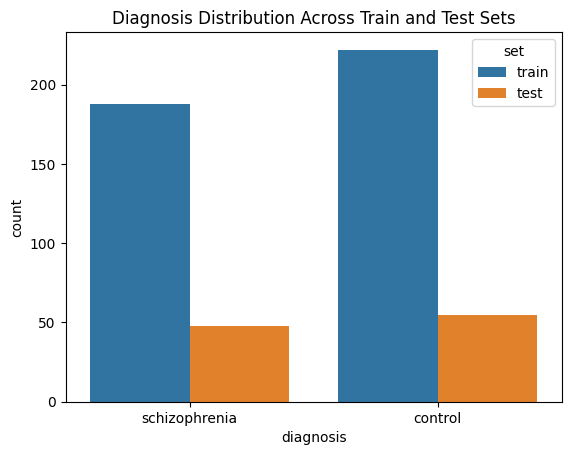

In [13]:
sns.countplot(x="diagnosis", data=participants, hue="set")
plt.title("Diagnosis Distribution Across Train and Test Sets")
plt.show()

## Correlation

In [14]:
X_df=pd.DataFrame(X_train)
corr_matrix = X_df.corr()

threshold = 0.5

corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

significant_corr = corr_pairs[abs(corr_pairs['Correlation']) >= threshold]


In [15]:
significant_corr

,Variable 1,Variable 2,Correlation
0,0,1,0.896139
28,0,30,0.511638
139,0,142,-0.666178
140,0,143,-0.646478
147,0,150,-0.519031
...,...,...,...
39055,280,282,0.642832
39056,280,283,0.563024
39057,281,282,0.580356
39058,281,283,0.569726


#### we can see multicolinearity

## PCA on ROIs

                 sum_sq     df          F        PR(>F)
diagnosis   2606.207928    1.0  29.245287  9.808873e-08
Residual   45538.013350  511.0        NaN           NaN
                 sum_sq     df          F    PR(>F)
diagnosis    791.094363    1.0  10.876419  0.001042
Residual   37167.493121  511.0        NaN       NaN


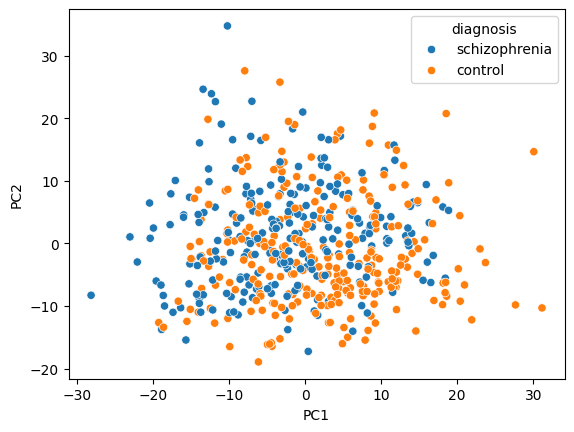

In [16]:
PCs = PCA(n_components=2).fit_transform(rois)
participants['PC1'], participants['PC2']  = PCs[:, 0], PCs[:, 1]

sns.scatterplot (x="PC1", y="PC2", hue="diagnosis",  data=participants)
oneway = smf.ols('PC1 ~ diagnosis', participants).fit()
print(sm.stats.anova_lm(oneway, typ=2))
oneway = smf.ols('PC2 ~ diagnosis', participants).fit()
print(sm.stats.anova_lm(oneway, typ=2))

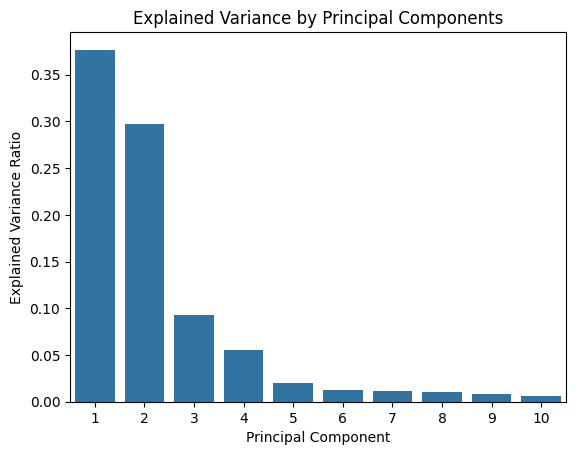

In [17]:
pca = PCA(n_components=10)
pca.fit(rois)
explained_variance = pca.explained_variance_ratio_
sns.barplot(x=np.arange(1, 11), y=explained_variance)
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [18]:
loadings = pd.DataFrame(
    data=pca.components_,  
    columns=rois.columns, 
    index=[f'PC{i+1}' for i in range(pca.n_components_)]  
)

# loadings for PC1 and PC2
print("Loadings for PC1:")
print(loadings.loc["PC1"].sort_values(ascending=False).head(10))  

print("\nLoadings for PC2:")
print(loadings.loc["PC2"].sort_values(ascending=False).head(10)) 

Loadings for PC1:
lExtCbe_GM_Vol      0.427184
rExtCbe_GM_Vol      0.414926
lMidFroGy_GM_Vol    0.243269
rMidFroGy_GM_Vol    0.233375
rMidTemGy_GM_Vol    0.188860
lMidTemGy_GM_Vol    0.182666
rSupFroGy_GM_Vol    0.165471
lSupFroGy_GM_Vol    0.164292
rPCu_GM_Vol         0.142188
lPrcGy_GM_Vol       0.135102
Name: PC1, dtype: float64

Loadings for PC2:
lExtCbe_CSF_Vol      0.326782
lLatVen_CSF_Vol      0.322000
rExtCbe_CSF_Vol      0.299416
rLatVen_CSF_Vol      0.268294
lMidFroGy_CSF_Vol    0.251474
rMidFroGy_CSF_Vol    0.240737
lSupFroGy_CSF_Vol    0.221744
rSupFroGy_CSF_Vol    0.221011
lPoCGy_CSF_Vol       0.195736
rPoCGy_CSF_Vol       0.177319
Name: PC2, dtype: float64


# LDA

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import roc_auc_score

LDA ROC AUC Score: 0.7015


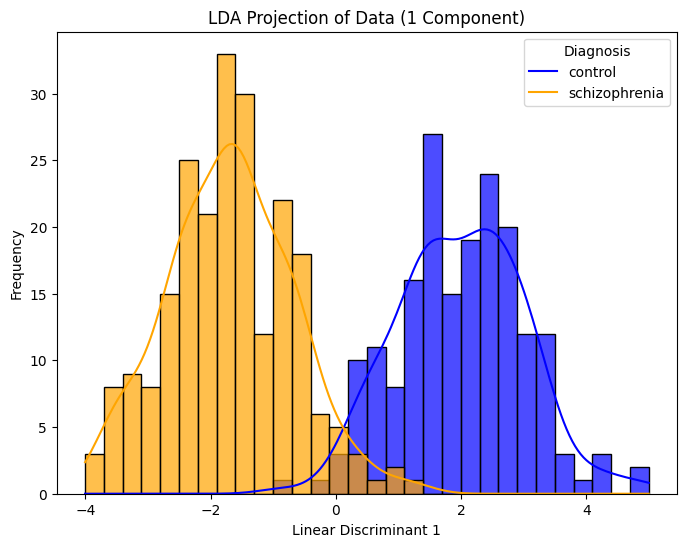

In [20]:

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Convert categorical diagnosis to numerical labels
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(participants_train["diagnosis"].values)  
y_test_encoded = label_encoder.transform(participants_test["diagnosis"].values)

# Apply LDA with correct number of components
lda = LinearDiscriminantAnalysis(n_components=1)  
X_train_lda = lda.fit_transform(X_train_scaled, y_train_encoded)
X_test_lda = lda.transform(X_test_scaled)

# Compute ROC AUC score for LDA
lda_preds = lda.predict_proba(X_test_scaled)[:, 1]
lda_roc_auc = roc_auc_score(y_test_encoded, lda_preds)
print(f"LDA ROC AUC Score: {lda_roc_auc:.4f}")

# Visualizing LDA results (only 1 component available)
lda_df = pd.DataFrame(X_train_lda, columns=["LD1"])
lda_df["diagnosis"] = y_train_encoded 

plt.figure(figsize=(8, 6))
sns.histplot(data=lda_df, x="LD1", hue=lda_df["diagnosis"], kde=True, bins=30, palette=["orange", "blue"], alpha=0.7)
plt.title("LDA Projection of Data (1 Component)")
plt.xlabel("Linear Discriminant 1")
plt.ylabel("Frequency")
plt.legend(title="Diagnosis", labels=label_encoder.classes_)  
plt.show()


## Machine learning


Load concatenated data: 284 features from ROIs and 331,695 features from VBM.

In [21]:

import problem

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [22]:
X_train, y_train = problem.get_train_data(datatype="rois")
X_test, y_test = problem.get_test_data(datatype="rois")

## Feature extractor of ROIs 

In [23]:
class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]


fe = ROIsFeatureExtractor()
print(fe.transform(X_train).shape)



(410, 284)


## Design of predictors and their evaluation using CV and test set


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics


### LogisticRegression

In [31]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    LogisticRegression())
    
cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())


# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


# 5CV
bACC=0.69 ROC-AUC=0.75
# Test
bACC=0.74 ROC-AUC=0.81


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.3s finished


### Logistic Regression with l2 (Ridge)

In [87]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    LogisticRegression(penalty='l2', C=.1))
# This class implements regularized logistic regression. C is the Inverse of regularization strength.
# Large value => no regularization.
    
cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())


# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

# 5CV
bACC=0.70 ROC-AUC=0.76
# Test
bACC=0.72 ROC-AUC=0.82


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://

### Logistic Regression with l1 (Lasso)

In [83]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    LogisticRegression(penalty='l1', C=.1, solver='saga'))
# This class implements regularized logistic regression. C is the Inverse of regularization strength.
# Large value => no regularization.
    
cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())


# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


# 5CV
bACC=0.67 ROC-AUC=0.76
# Test
bACC=0.72 ROC-AUC=0.78


/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter 

### Regression with Elastic Net

In [89]:
############ GridSearch ##############

param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10],   
    'logisticregression__l1_ratio': [0.1, 0.5, 0.9] 
}

pipeline = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000, random_state=42)
)
scoring = {
    'roc_auc': 'roc_auc',
    'balanced_accuracy': metrics.make_scorer(metrics.balanced_accuracy_score)
}

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,  
    verbose=1,  
    n_jobs=5,  
    refit='roc_auc' )


grid_search.fit(X_train, y_train) 

print("Best params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

best_index = grid_search.best_index_
print("Best Balanced Accuracy:", grid_search.cv_results_['mean_test_balanced_accuracy'][best_index])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.9}
Best ROC-AUC: 0.8355623087202033
Best Balanced Accuracy: 0.7623519691940744


In [90]:

cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    LogisticRegression(penalty='elasticnet', C=0.1,l1_ratio= 0.9, solver='saga'))
    
cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())


# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

# 5CV
bACC=0.67 ROC-AUC=0.76
# Test
bACC=0.72 ROC-AUC=0.79


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-p

### Linear SVM with l1 regularization

In [98]:
###### Grid Search ######

param_grid = {
    'linearsvc__C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'linearsvc__class_weight': [None, 'balanced']  
}

pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(penalty='l1', dual=False, max_iter=5000, random_state=42)  # L1 regularization => dual=False
)

# Define scoring metrics for GridSearchCV
scoring = {
    'roc_auc': 'roc_auc',
    'balanced_accuracy': metrics.make_scorer(metrics.balanced_accuracy_score)
}

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,  
    cv=5,  
    verbose=1,  
    n_jobs=5,  
    refit='roc_auc' 
)


grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)
best_index = grid_search.best_index_
print("Best Balanced Accuracy:", grid_search.cv_results_['mean_test_balanced_accuracy'][best_index])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chekalisa/Downloads/brain_ana

Best parameters: {'linearsvc__C': 0.01, 'linearsvc__class_weight': None}
Best ROC-AUC: 0.8213057315688894
Best Balanced Accuracy: 0.7561379082431714


/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chekalisa/Downloads/brain_ana

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

# model with calibration
svc = LinearSVC(penalty='l1', C=0.01, dual=False, max_iter=5000, random_state=42)
calibrated_svc = CalibratedClassifierCV(svc, method='sigmoid', cv=5)  # Calibration to add predict_proba


estimator = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    calibrated_svc   
)


cv_results = cross_validate(
    estimator, X_train, y_train, 
    scoring=['balanced_accuracy', 'roc_auc'], 
    cv=problem.get_cv(X_train, y_train),
    verbose=1, return_train_score=True, n_jobs=5
)


print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())


estimator.fit(X_train, y_train)


y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]  


bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)

print("# Test")
print('bACC=%.2f' % bacc_test, 'ROC-AUC=%.2f' % auc_test)

# 5CV
bACC=0.75 ROC-AUC=0.80
# Test
bACC=0.76 ROC-AUC=0.83


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


#### good results but on ramp it overfits

### Non linear SVM with regularization 

In [ ]:
######## GridSearch ############

param_grid = {
    'svc__C': [0.1, 1, 10], 
    'svc__kernel': ['linear', 'rbf'],  
    'svc__gamma': ['scale', 'auto', 0.01, 0.1] 
    
}


pipeline = make_pipeline(
    StandardScaler(),
    SVC(probability=True, random_state=42) 
)


scoring = {
    'roc_auc': 'roc_auc', 
    'balanced_accuracy': metrics.make_scorer(metrics.balanced_accuracy_score) 
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring, 
    cv=5, 
    verbose=1,  
    n_jobs=5, 
    refit='roc_auc'  
)


grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)
best_index = grid_search.best_index_

print("Best Balanced Accuracy:", grid_search.cv_results_['mean_test_balanced_accuracy'][best_index])

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Best ROC-AUC: 0.8281752087015246
Best Balanced Accuracy: 0.7314721180510654


In [ ]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    SVC(probability=True, random_state=42,C= 1, gamma ='auto', kernel ='rbf'))
    
cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())


estimator.fit(X_train, y_train)

y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.3s finished


# 5CV
bACC=0.73 ROC-AUC=0.82
# Test
bACC=0.75 ROC-AUC=0.84


### Gradient Boost

In [47]:
######## GridSearch ############

param_grid = {
    'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.3,], 
    'gradientboostingclassifier__n_estimators': [50, 100, 150],        
    'gradientboostingclassifier__max_depth': [3, 4, 5],                 
    'gradientboostingclassifier__min_samples_split': [2, 5, 10], 
    'gradientboostingclassifier__subsample': [0.8, 0.9, 1],                         
}
# Define scoring metrics for GridSearchCV
scoring = {
    'roc_auc': 'roc_auc',
    'balanced_accuracy': metrics.make_scorer(metrics.balanced_accuracy_score)
}

pipeline = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),              
    GradientBoostingClassifier()   
)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,  
    cv=5,  
    verbose=1, 
    n_jobs=5,  
    refit='roc_auc' 
)

# Fit 
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)
best_index = grid_search.best_index_
print("Best Balanced Accuracy:", grid_search.cv_results_['mean_test_balanced_accuracy'][best_index])


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__subsample': 0.8}
Best ROC-AUC: 0.837605356552725
Best Balanced Accuracy: 0.7564009942957312


In [48]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    GradientBoostingClassifier(
                learning_rate=0.01,  
                max_depth=3,  
                min_samples_split =2, 
                n_estimators=100,
                subsample= 0.8,
                
                random_state=42))
    
cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())


# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.6s finished


# 5CV
bACC=0.73 ROC-AUC=0.81
# Test
bACC=0.75 ROC-AUC=0.82


### RandomForest

In [28]:
##### GridSearch #########


param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200], 
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],  
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],    
}

scoring = {
    'roc_auc': 'roc_auc',
    'balanced_accuracy': metrics.make_scorer(metrics.balanced_accuracy_score)
}


pipeline = make_pipeline(
    StandardScaler(),               
    RandomForestClassifier(random_state=42)
)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,  
    cv=5,  
    verbose=1, 
    n_jobs=5,  
    refit='roc_auc' 
)


grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)
best_index = grid_search.best_index_
print("Best Balanced Accuracy:", grid_search.cv_results_['mean_test_balanced_accuracy'][best_index])


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 200}
Best ROC-AUC: 0.8129134158081527
Best Balanced Accuracy: 0.731173039067776


In [29]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    RandomForestClassifier(max_depth =10, min_samples_leaf= 2, min_samples_split=10,
                            n_estimators= 200))
    
cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())


estimator.fit(X_train, y_train)

y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.6s finished


# 5CV
bACC=0.72 ROC-AUC=0.78
# Test
bACC=0.73 ROC-AUC=0.81


## Stacking

combined GB and SVM


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

cv = problem.get_cv(X_train, y_train)


base_models = [
        ('gb', GradientBoostingClassifier(
            learning_rate=0.01, 
            max_depth=3,  
            min_samples_split=2, 
            n_estimators=100,  
            subsample=0.8,
            random_state=42
        )),
        ('svc', SVC(
            probability=True, 
            random_state=42, 
            C=1,   
            gamma='auto',  
            kernel='rbf'
        ))
]


stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=5000),  
    cv=3,  
    n_jobs=-1  
)


estimator = Pipeline([
        ('scaler', StandardScaler()),
        ('remove_constant', VarianceThreshold(threshold=0.01)),  # excude constants
        ('feature_selection', SelectKBest(score_func=f_classif, k=150)), # select 150 variables 
        ('stacking', stacking_clf)  
    ])


cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())

print(X_train.shape)

# Refit on all train
estimator.fit(X_train, y_train)

# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.4s


# 5CV
bACC=0.75 ROC-AUC=0.81
(410, 284)


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.8s finished


# Test
bACC=0.75 ROC-AUC=0.82


# Feature Importance

/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/chekalisa/Downloads/brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024/.ML_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Use

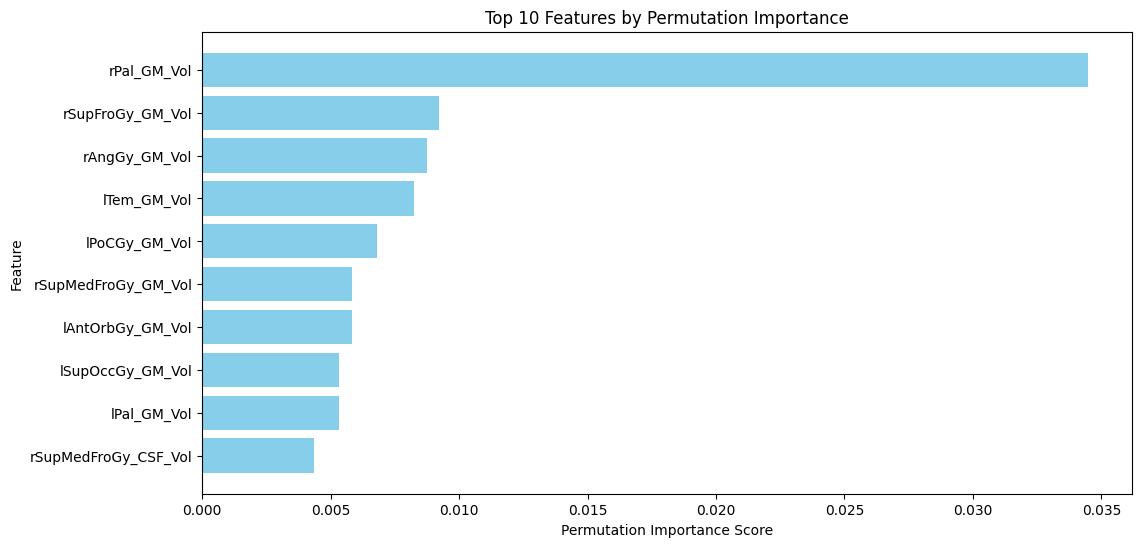

In [106]:
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance


# --- Permutation Importance ---
# Checking if rois_test is a DataFrame to use its feature names
if isinstance(rois_test, pd.DataFrame):
    feature_names = rois_test.columns.tolist()  # Use actual feature names
else:
    feature_names = [f"Feature {i}" for i in range(rois_test.shape[1])]  


perm_importance = permutation_importance(
    estimator, rois_test, y_test, n_repeats=20, random_state=42, n_jobs=-1
)

# Create a DataFrame with feature importance
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,  
    'Importance': perm_importance.importances_mean
})

# Sort by descending importance and select the top 10
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False).head(10)

# Visualization of the top 10 features
plt.figure(figsize=(12, 6))
plt.barh(perm_importance_df["Feature"], perm_importance_df["Importance"], color='skyblue')
plt.xlabel("Permutation Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Features by Permutation Importance")
plt.gca().invert_yaxis()
plt.show()
